### Load Libraries

In [1]:
import os, sys
project_home = "/Users/pitehrhurtado/Documents/Operation-Researchs/clustering_discretization/src/"
if project_home not in sys.path:
    sys.path = [project_home] + sys.path

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd

import logging

##### Configs

In [3]:
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [4]:
# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)

### Load Data
#### A. grid data

In [5]:
grid_df = gpd.read_file("../data/geodf.geojson")

#### B. pixel data

In [6]:
df = pd.read_csv("../data/output_layer_process.csv")

## Aggregation Process

In [7]:
from app.aggregations.pixel import Meta_Pixel, Pixel
from shapely.geometry import Polygon
from matplotlib import pyplot as plt
import geopandas as gpd

ModuleNotFoundError: No module named 'app.aggregations'

In [8]:
LAYER_SELECTED = 2

In [12]:
df_used = df[df.layer == LAYER_SELECTED].reset_index(drop=True)

In [13]:
merged_df = grid_df.merge(df_used,
                         left_on="cell_id",
                         right_on="pixel",
                         how="left")
merged_df["demand_daily"] = merged_df["demand_daily"].fillna(0)
merged_df["pixel"] = merged_df.apply(lambda x: x["pixel"] if not x["pixel"] else x["cell_id"], axis=1)

In [14]:
merged_df

,cell_id,geometry,year,month,cod_customer,lat,lon,demand,n_dates,demand_daily,layer,pixel
0,0,"POLYGON ((-68.17297 -16.60097, -68.16360 -16.6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0
1,1,"POLYGON ((-68.16360 -16.60097, -68.15423 -16.6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1
2,2,"POLYGON ((-68.15423 -16.60097, -68.14486 -16.6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2
3,3,"POLYGON ((-68.14486 -16.60097, -68.13549 -16.6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,3
4,4,"POLYGON ((-68.13549 -16.60097, -68.12612 -16.6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...
766,299,"POLYGON ((-68.06989 -16.43832, -68.06052 -16.4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,299
767,300,"POLYGON ((-68.06052 -16.43832, -68.05115 -16.4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,300
768,301,"POLYGON ((-68.05115 -16.43832, -68.04178 -16.4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,301
769,302,"POLYGON ((-68.04178 -16.43832, -68.03240 -16.4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,302


In [15]:
## Create Pixel Object
pixels = {}
for element in merged_df.to_dict(orient="records"):
    if element["pixel"] in pixels:
        pixels[element['pixel']].add_customer(element)
    else:
        init = {
            "id": element["pixel"],
            "corner_down_left": list(element["geometry"].exterior.coords)[3],
            "corner_down_right": list(element["geometry"].exterior.coords)[2],
            "corner_up_right": list(element["geometry"].exterior.coords)[1],
            "corner_up_left": list(element["geometry"].exterior.coords)[0],
            "demand_daily": element["demand_daily"]
        }
        #logger.info(f"Creating pixel {init}\n")
        pixels[element['pixel']] = Pixel(init)
logger.info(f"Total Pixel object created {len(pixels)}")

INFO:__main__:Total Pixel object created 304


In [16]:
## Logging descriptive metrics
for k, p in pixels.items():
    avg_demand = p.get_avg_demand()
    std_demand = p.get_std_demand()
    n_customers = p.get_n_customers()
    if n_customers > 0:
        logger.info(
            f"PIXEL - {k}: avg_demand: {avg_demand:.2f} - std_demand: {std_demand:.2f} - n_customers: {n_customers}"
        )

INFO:__main__:PIXEL - 42: avg_demand: 69.00 - std_demand: 6.16 - n_customers: 3
INFO:__main__:PIXEL - 73: avg_demand: 80.33 - std_demand: 12.72 - n_customers: 12
INFO:__main__:PIXEL - 120: avg_demand: 72.33 - std_demand: 10.37 - n_customers: 3
INFO:__main__:PIXEL - 121: avg_demand: 96.42 - std_demand: 28.16 - n_customers: 33
INFO:__main__:PIXEL - 122: avg_demand: 85.20 - std_demand: 24.60 - n_customers: 30
INFO:__main__:PIXEL - 127: avg_demand: 87.00 - std_demand: 0.00 - n_customers: 1
INFO:__main__:PIXEL - 135: avg_demand: 74.25 - std_demand: 9.58 - n_customers: 4
INFO:__main__:PIXEL - 137: avg_demand: 93.52 - std_demand: 24.18 - n_customers: 27
INFO:__main__:PIXEL - 138: avg_demand: 79.00 - std_demand: 16.27 - n_customers: 13
INFO:__main__:PIXEL - 141: avg_demand: 120.81 - std_demand: 55.20 - n_customers: 21
INFO:__main__:PIXEL - 142: avg_demand: 72.00 - std_demand: 0.00 - n_customers: 1
INFO:__main__:PIXEL - 146: avg_demand: 92.70 - std_demand: 30.17 - n_customers: 10
INFO:__main__:

In [17]:
pixels[200].__dict__

{'id': 200,
 'corner_down_left': (-68.09800373252476, -16.501574644042172),
 'corner_down_right': (-68.08863241659036, -16.501574644042172),
 'corner_up_right': (-68.08863241659036, -16.492538357136915),
 'corner_up_left': (-68.09800373252476, -16.492538357136915),
 'demand': [0.0],
 'pixels_adyacent': [],
 'belong_meta_pixel': False}

In [18]:
def plot_pixels(pixels: list[Pixel], metric: str, title: str):
    polygons = []
    demands = []
    std = []
    n_customers = []
    ids = []

    for pixel in pixels:
        polygon = pixel.get_polygon()
        demand = pixel.get_avg_demand()
        std_ = pixel.get_std_demand()
        n_customer = pixel.get_n_customers()
        polygons.append(polygon)
        demands.append(demand)
        std.append(std_)
        n_customers.append(n_customer)
        ids.append(pixel.id)

    data = {"geometry": polygons,
            "demand": demands,
            "std": std,
            "n_customer": n_customers,
            "id": ids,}
    gdf = gpd.GeoDataFrame(data)

    fig, ax = plt.subplots(figsize=(10, 10))
    
    if metric != "id":
        gdf[gdf[metric] == 0].boundary.plot(ax=ax, linewidth=1, edgecolor="lightgrey")

        gdf[gdf[metric] > 0].plot(
            ax=ax,
            column=metric,
            cmap="Blues",  
            linewidth=1,
            edgecolor="lightgrey",
            legend=True,
        )
    else:
        gdf[gdf["demand"] > 0].plot(
            ax=ax,
            cmap="Blues",  
            linewidth=1,
            edgecolor="lightgrey",
            legend=True,
        )

    for idx, row in gdf[gdf[metric] > 0].iterrows():
        ax.annotate(
            text=round(row[metric],1),
            xy=(row["geometry"].centroid.x, row["geometry"].centroid.y),
            xytext=(3, 3),
            textcoords="offset points",
            ha="center",
            fontsize=8,
        )

    plt.title(f"Plot about {title} ")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    plt.show()


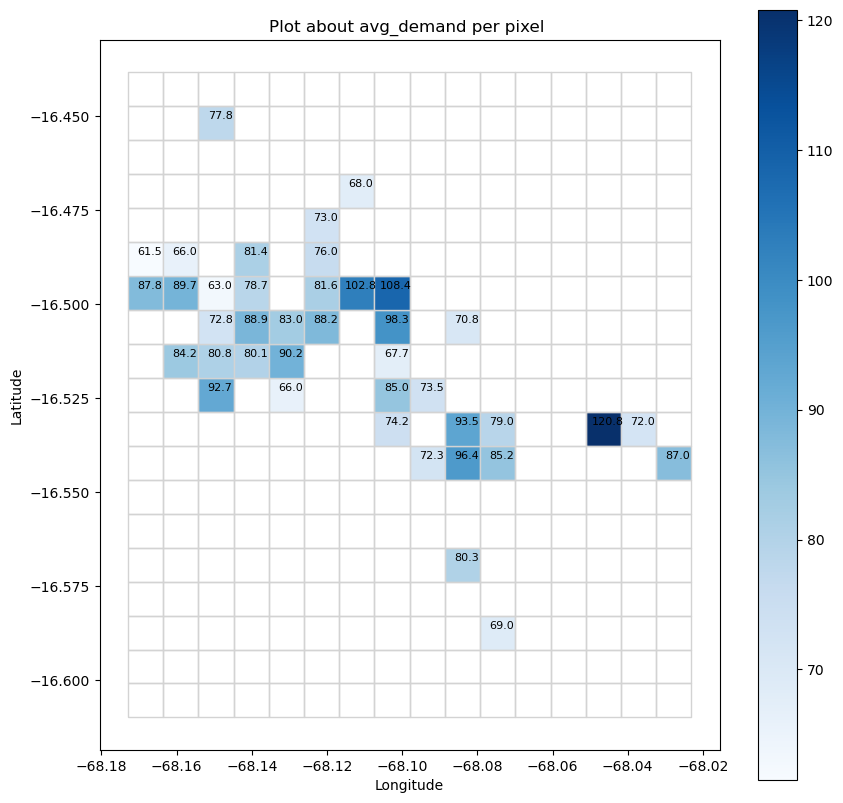

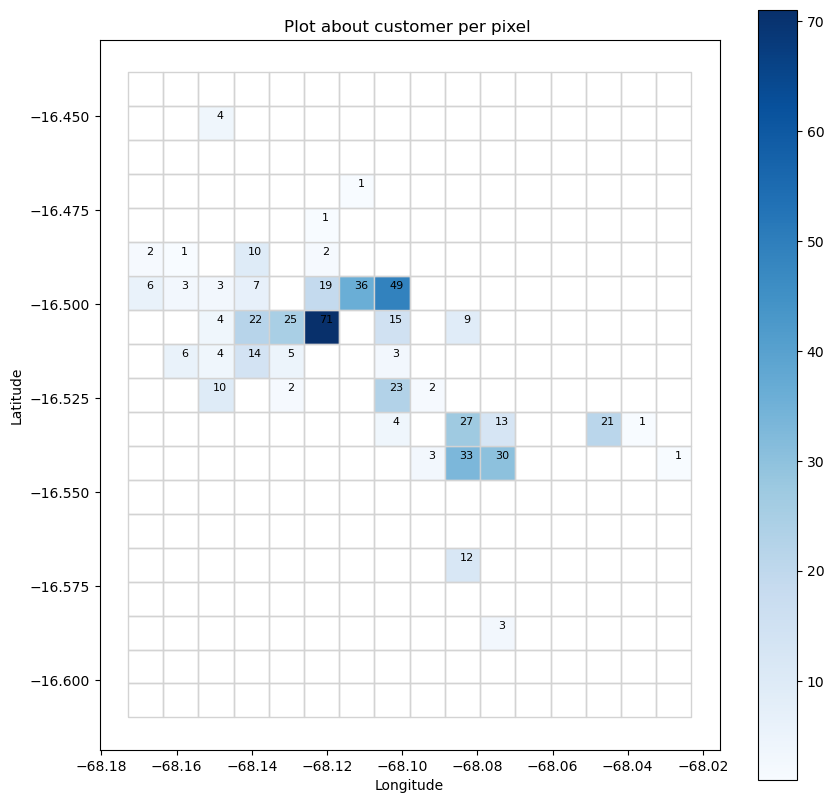

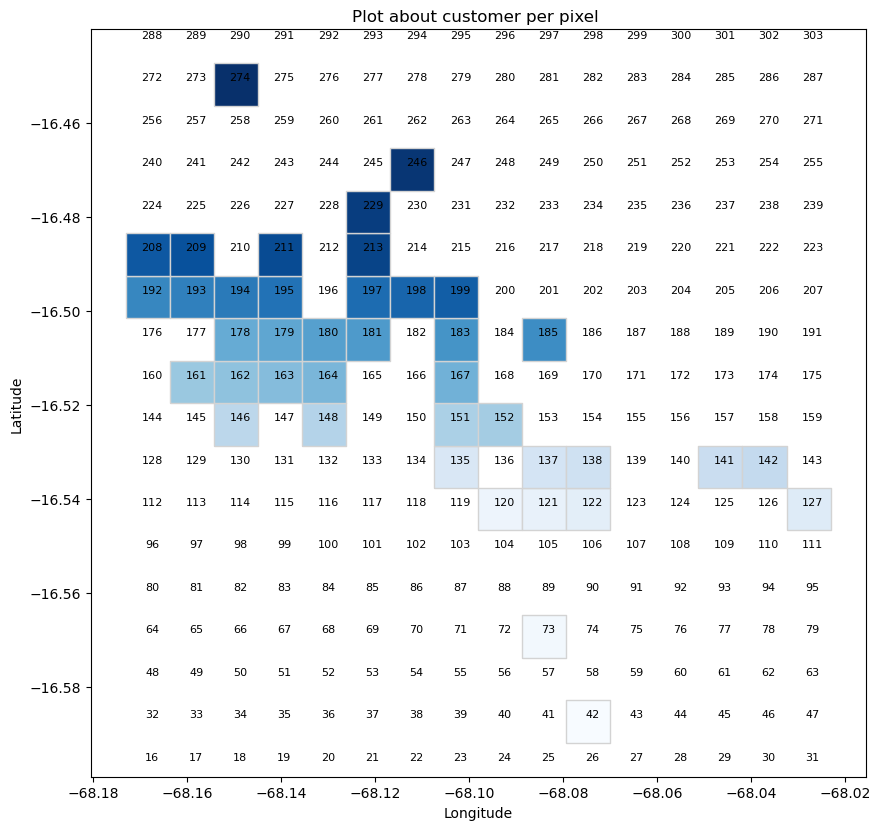

In [60]:
plot_pixels(pixels.values(), 'demand', 'avg_demand per pixel')
#plot_pixels(pixels.values(), 'std', 'std_demand per pixel')
plot_pixels(pixels.values(), 'n_customer', 'customer per pixel')
plot_pixels(pixels.values(), 'id', 'customer per pixel')

In [52]:
dict_to_agg = {
    208: [209, 192, 193],
    211: [195],
    194: [178, 162, 146],
    180: [164, 148],
    229: [213, 197],
    199: [183, 167],
    151: [135],
    120: [121],
    141: [142],
    137: [138],
    179: [163],
}

## Proceso de agregación Manual

In [53]:
meta_pixels = []
for k,p in pixels.items():
    if k in dict_to_agg:
        new_meta_pixel = Meta_Pixel(p)
        for adj_pixel in dict_to_agg[k]:
            new_meta_pixel.add_pixel(pixels[adj_pixel])
        meta_pixels.append(new_meta_pixel)
    else:
        is_ = False
        for element in dict_to_agg.values():
            if k in element:
                is_ = True
        
        if not is_:
            meta_pixels.append(Meta_Pixel(p))
    

In [54]:
for meta in meta_pixels:
    meta.construct_meta_pixel()

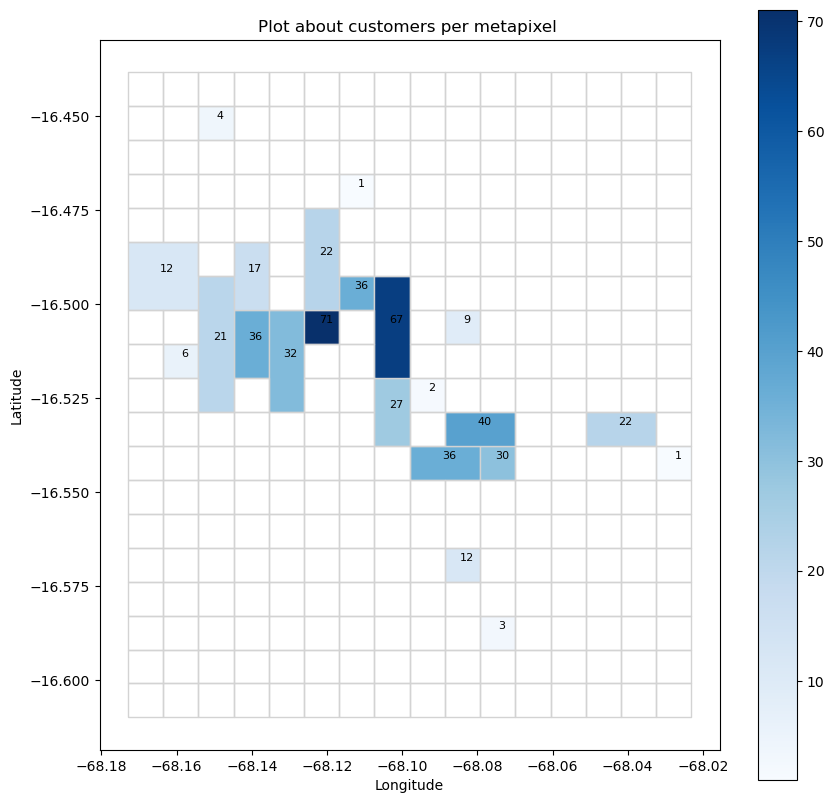

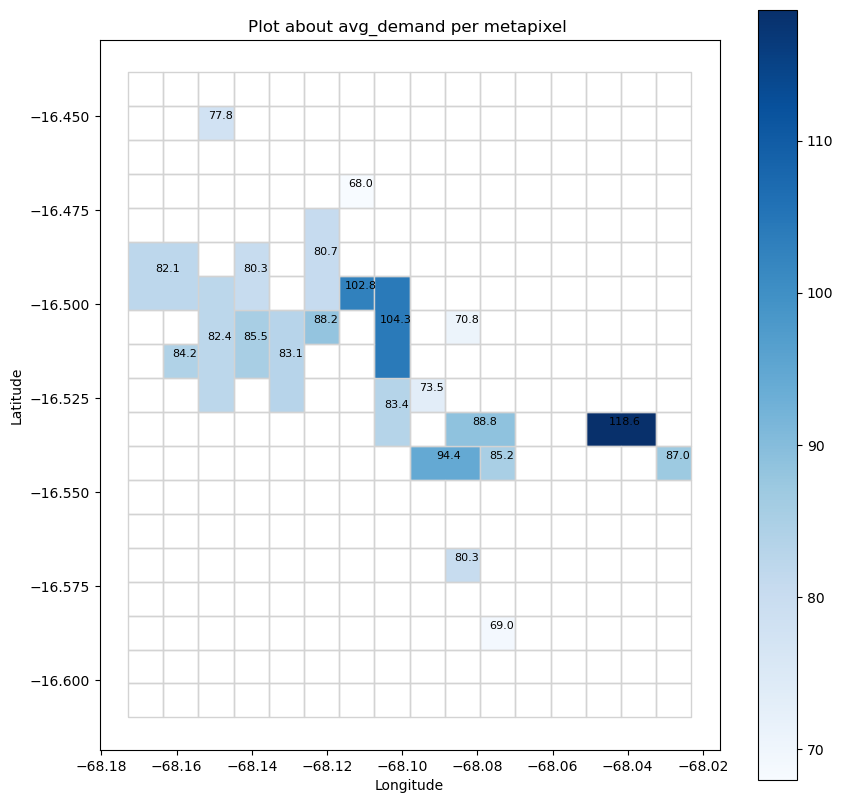

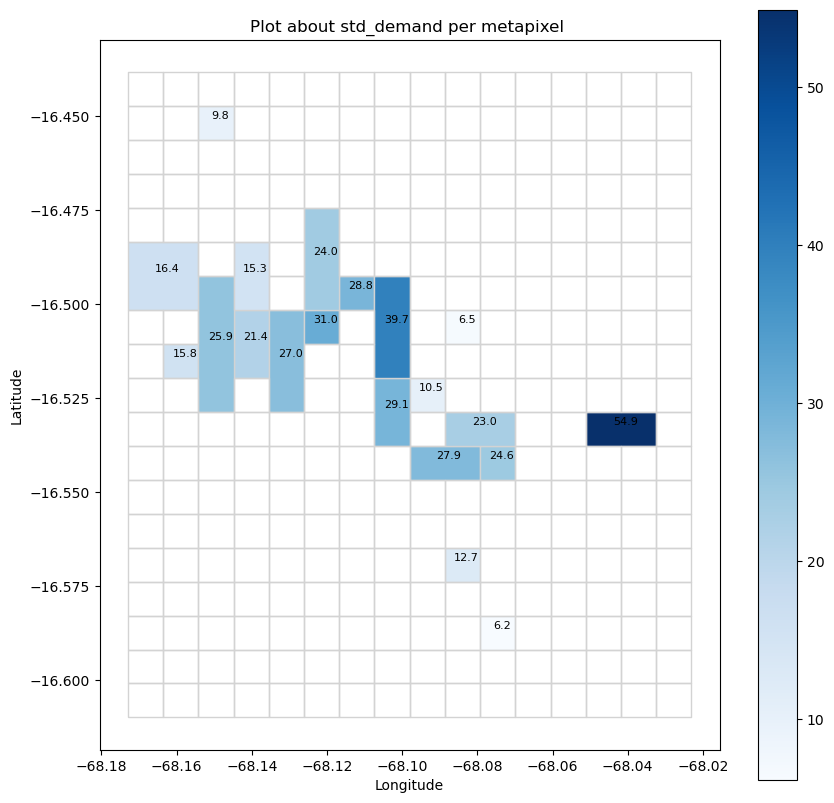

In [55]:
plot_pixels(meta_pixels, 'n_customer', 'customers per metapixel')
plot_pixels(meta_pixels, 'demand', "avg_demand per metapixel")
plot_pixels(meta_pixels, 'std', 'std_demand per metapixel')

### Exportar

In [56]:
output = {
    "id":[],
    "centroid_x": [],
    "cenotrid_y": [],
    "demand": [],
    "n_customer": [],
    "area":[],
}
for mp in meta_pixels:
    output["id"].append(f"{LAYER_SELECTED}-{mp.id}")
    output["centroid_x"].append(mp.get_polygon().centroid.x)
    output["cenotrid_y"].append(mp.get_polygon().centroid.y)
    output["demand"].append(mp.get_avg_demand())
    output["n_customer"].append(mp.get_n_customers())
    output['area'].append(mp.area)

df_output = pd.DataFrame.from_dict(output)

In [58]:
df_output[df_output.demand>0]

,id,centroid_x,cenotrid_y,demand,n_customer,area
42,2-42,-68.074575,-16.587419,69.000000,3,1
73,2-73,-68.083947,-16.569347,80.333333,12,1
120,2-120,-68.088632,-16.542238,94.416667,36,2
121,2-122,-68.074575,-16.542238,85.200000,30,1
126,2-127,-68.027719,-16.542238,87.000000,1,1
135,2-137,-68.079261,-16.533202,88.800000,40,2
138,2-141,-68.041776,-16.533202,118.590909,22,2
145,2-151,-68.102689,-16.528684,83.407407,27,2
146,2-152,-68.093318,-16.524165,73.500000,2,1
155,2-161,-68.158917,-16.515129,84.166667,6,1


In [59]:
df_output.to_csv(f"../data/output_{LAYER_SELECTED}_pixel_aggregation_process.csv", index=False)